In [ ]:
import pandas as pd

# Load your CSV into df
df = pd.read_csv(r'C:\Users\hp\Documents\nova-financial-news-sentiment\Nova-financial-news-sentiment-week1\data\raw_analyst_ratings.csv')


In [8]:
# Normalize dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['trading_date'] = df['date'].dt.date

# Since all 'stock' values are 'A', ticker = Agilent Technologies
ticker = "A"

print("Loaded rows:", len(df))

Loaded rows: 55987


In [10]:
# SENTIMENT ANALYSIS

sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['headline'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

print("Sentiment example:")
print(df[['headline', 'sentiment']].head())

Sentiment example:
                                            headline  sentiment
0            Stocks That Hit 52-Week Highs On Friday      0.000
1         Stocks That Hit 52-Week Highs On Wednesday      0.000
2                      71 Biggest Movers From Friday      0.000
3       46 Stocks Moving In Friday's Mid-Day Session      0.000
4  B of A Securities Maintains Neutral on Agilent...      0.296


In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis on your DataFrame 'df'
df['sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Preview
df[['headline', 'sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,headline,sentiment
0,Stocks That Hit 52-Week Highs On Friday,0.000
1,Stocks That Hit 52-Week Highs On Wednesday,0.000
2,71 Biggest Movers From Friday,0.000
3,46 Stocks Moving In Friday's Mid-Day Session,0.000
4,B of A Securities Maintains Neutral on Agilent...,0.296


In [14]:
# Aggregate daily sentiment per stock
daily_sentiment = df.groupby(['stock', 'date'])['sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)

# Preview
daily_sentiment.head()


,stock,date,avg_sentiment
0,A,2020-05-22 08:06:17-04:00,0.000
1,A,2020-05-22 08:37:59-04:00,-0.128
2,A,2020-05-22 09:07:04-04:00,0.296
3,A,2020-05-22 09:36:20-04:00,0.000
4,A,2020-05-22 11:23:25-04:00,-0.128


In [16]:
import yfinance as yf

symbol = 'A'
prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')

# Inspect the columns
print(prices.columns)


C:\Users\hp\AppData\Local\Temp\ipykernel_29020\3026178610.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'A'),
            (  'High', 'A'),
            (   'Low', 'A'),
            (  'Open', 'A'),
            ('Volume', 'A')],
           names=['Price', 'Ticker'])


In [20]:
import yfinance as yf

symbol = 'A'
prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')

# Calculate daily returns using the MultiIndex column
prices['daily_return'] = prices[('Close', symbol)].pct_change()

# Reset index and normalize date
prices = prices.reset_index()
prices['date'] = prices['Date'].dt.date

# Keep only necessary columns
prices = prices[['date', 'daily_return']]
prices.head()


C:\Users\hp\AppData\Local\Temp\ipykernel_29020\1599816391.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(symbol, start='2020-01-01', end='2020-12-31')
[*********************100%***********************]  1 of 1 completed


Price,date,daily_return
Ticker,,
0,2020-01-02,NaN
1,2020-01-03,-0.016056
2,2020-01-06,0.002956
3,2020-01-07,0.003065
4,2020-01-08,0.009873


In [27]:
print("daily_sentiment columns:", daily_sentiment.columns)
print("prices columns:", prices.columns)


daily_sentiment columns: Index(['stock', 'date', 'avg_sentiment'], dtype='object')
prices columns: Index(['level_0', 'index', 'date_', 'daily_return_'], dtype='object')


In [29]:
# Convert daily_sentiment['date'] to datetime.date
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date

# Convert prices['date'] to datetime.date (remove timezone if present)
prices['date'] = pd.to_datetime(prices['date']).dt.date


In [30]:
df_merged = pd.merge(daily_sentiment, prices[['date', 'daily_return']], on='date', how='inner')

# Shift sentiment for next-day correlation
df_merged['avg_sentiment_next_day'] = df_merged['avg_sentiment'].shift(1)

df_merged.head()


,stock,date,avg_sentiment,daily_return,avg_sentiment_next_day
0,A,2020-05-22,0.000,0.052384,NaN
1,A,2020-05-22,-0.128,0.052384,0.000
2,A,2020-05-22,0.296,0.052384,-0.128
3,A,2020-05-22,0.000,0.052384,0.296
4,A,2020-05-22,-0.128,0.052384,0.000


In [31]:
# Pearson correlation between next-day sentiment and returns
correlation = df_merged['avg_sentiment_next_day'].corr(df_merged['daily_return'])
print(f"Pearson correlation: {correlation:.4f}")


Pearson correlation: 0.0355


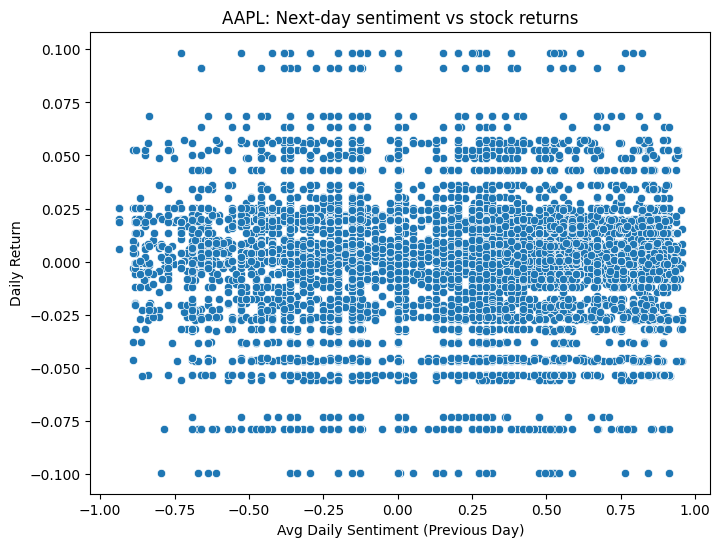

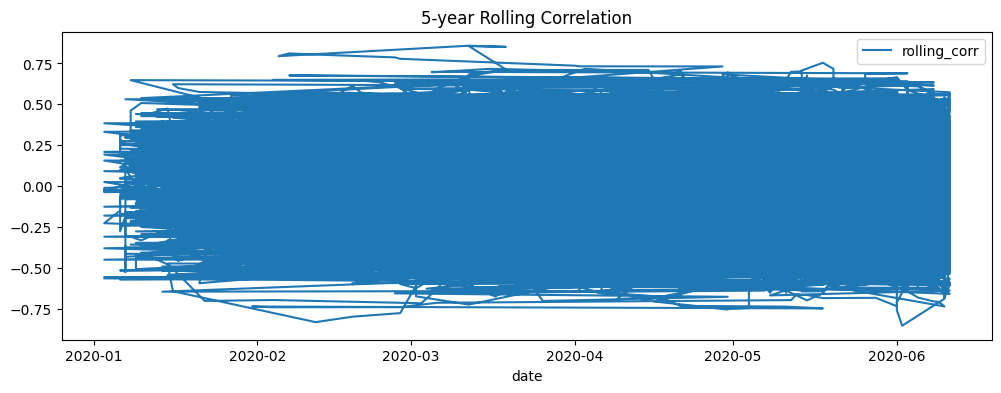

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_sentiment_next_day', y='daily_return', data=df_merged)
plt.title(f"{symbol}: Next-day sentiment vs stock returns")
plt.xlabel("Avg Daily Sentiment (Previous Day)")
plt.ylabel("Daily Return")
plt.show()

# Rolling correlation
df_merged['rolling_corr'] = df_merged['avg_sentiment_next_day'].rolling(window=20).corr(df_merged['daily_return'])
df_merged[['date','rolling_corr']].set_index('date').plot(figsize=(12,4), title='5-day Rolling Correlation')
plt.show()


In [40]:
# Keep only rows where both values exist
df_corr = df_plot[['sentiment_lag1', 'return']].dropna()

# Compute correlation
corr_val = pearsonr(df_corr['sentiment_lag1'], df_corr['return'])[0]


In [41]:
ax1.set_title(f"{symbol} – Next-Day News Sentiment vs Daily Return (r = {corr_val:.3f})")


Text(0.5, 1.0, 'AAPL – Next-Day News Sentiment vs Daily Return (r = 0.036)')

In [43]:
from scipy.stats import pearsonr

# Keep only rows where both columns are not NaN
df_corr = df_plot[['sentiment_lag1', 'return']].dropna()

# Compute Pearson correlation
corr_val = pearsonr(df_corr['sentiment_lag1'], df_corr['return'])[0]

print(f"Next-day sentiment vs return correlation: {corr_val:.3f}")


Next-day sentiment vs return correlation: 0.036
